<a href="https://colab.research.google.com/github/Gnkhakimova/CS5590-Cyber/blob/master/Lab_Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 2
Membership inference attack

In [0]:
import sys 
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline  
from skimage import io
import pickle
import os, shutil
import urllib.request
import tarfile
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, auc


import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataset import Dataset




# Part  - 1: Same target and shadow model, different datasets

# Hyperparameters

In [0]:
n_epochs = 7
batch_size = 48
lr = 0.01
k = 3



# Load data - CIFAR100

Files already downloaded and verified
Files already downloaded and verified


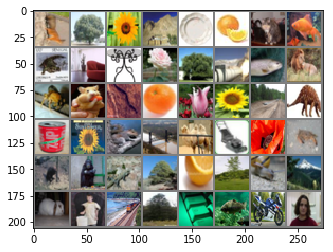

In [21]:
# define series of transforms to pre process images 
train_transform = torchvision.transforms.Compose([  
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
    


# load training set 
cifar100_trainset = torchvision.datasets.CIFAR100('../../../Datasets/', train=True, transform=train_transform, download=True)
cifar100_trainloader = torch.utils.data.DataLoader(cifar100_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar100_testset = torchvision.datasets.CIFAR100('../../../Datasets/', train=False, transform=test_transform, download=True)
cifar100_testloader = torch.utils.data.DataLoader(cifar100_testset, batch_size=batch_size, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar100_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))


# Load dataset - LFW

LFW already downloaded.


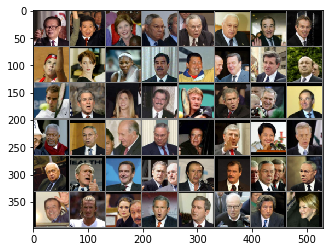

In [34]:
get_lfw('../../../Datasets/')


data_dir = "../../../Datasets/lfw/lfw_20/"

img_paths = []
for p in os.listdir(data_dir): 
    for i in os.listdir(os.path.join(data_dir,p)): 
        img_paths.append(os.path.join(data_dir,p,i))
        
people = []
people_to_idx = {}
people_idx = 0 
for i in img_paths: 
    name = i.split('/')[-2]
    if name not in people_to_idx: 
        people.append(name)
        people_to_idx[name] = people_idx
        people_idx += 1


n_lfw_classes = len(people)

img_paths = np.random.permutation(img_paths)

lfw_size = len(img_paths)

lfw_train_size = int(0.8 * lfw_size)

lfw_train_list = img_paths[:lfw_train_size]
lfw_test_list = img_paths[lfw_train_size:]

class LFWDataset(Dataset): 
    def __init__(self, file_list, class_to_label, transform=None): 
        self.file_list = file_list
        self.transform = transform
        
        self.people_to_idx = class_to_label
        
                
    def __len__(self): 
        return len(self.file_list)
    def __getitem__(self, idx): 
        img_path = self.file_list[idx]
        image = io.imread(img_path)
        label = self.people_to_idx[img_path.split('/')[-2]]
        
        if self.transform is not None: 
            image = self.transform(image)
        
        return image, label
        

# Data augmentation 
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(64),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(64),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

])
    

lfw_trainset = LFWDataset(lfw_train_list, people_to_idx, transform=train_transform)
lfw_testset = LFWDataset(lfw_test_list, people_to_idx, transform=test_transform)

lfw_trainloader = torch.utils.data.DataLoader(lfw_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
lfw_testloader = torch.utils.data.DataLoader(lfw_testset, batch_size=batch_size, shuffle=False, num_workers=2)


# display sample from dataset 
imgs,labels = iter(lfw_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))


# Helper functions

In [0]:
def get_lfw(datasets_dir):

    if os.path.isdir(os.path.join(datasets_dir,'lfw')):
        print('LFW already downloaded.')
        return

    if not os.path.isdir(datasets_dir):
        os.makedirs(datasets_dir)

    print('Downloading LFW.')

    url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
    urllib.request.urlretrieve(url, os.path.join(datasets_dir,'lfw.tgz'))

    tar = tarfile.open(os.path.join(datasets_dir,'lfw.tgz'))
    tar.extractall(path=os.path.join(datasets_dir,'lfw/'))

    os.rename(os.path.join(datasets_dir,'lfw/lfw/'), os.path.join(datasets_dir,'lfw/lfw_original/'))


    lfw_dir = os.path.join(datasets_dir,'lfw/lfw_original/')
    people_dir = os.listdir(lfw_dir)


    num_per_class = 20

    new_dir = os.path.join(datasets_dir,'lfw/lfw_'+str(num_per_class))

    if not os.path.isdir(new_dir):
        os.makedirs(new_dir)



    for p in people_dir:
        imgs = os.listdir(os.path.join(lfw_dir,p))
        if len(imgs) >= num_per_class:
            shutil.copytree(os.path.join(lfw_dir,p),os.path.join(new_dir,p))

    print('LFW successfully downloaded and preprocessed.')


In [0]:
class mlleaks_cnn(nn.Module): 
    def __init__(self, n_in=3, n_out=10, n_hidden=64, size=32): 
        super(mlleaks_cnn, self).__init__()
        
        self.n_hidden = n_hidden 
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(n_in, n_hidden, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(n_hidden), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(n_hidden, 2*n_hidden, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(2*n_hidden), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 

        fc_feature_size = calc_mlleaks_cnn_size(size)
        self.fc = nn.Linear(int(2*n_hidden * fc_feature_size * fc_feature_size), 128)
        self.output = nn.Linear(2*n_hidden, n_out)
        
    def forward(self, x): 
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        out = self.output(x)
        
        return out

In [0]:
def train(net, data_loader, test_loader, optimizer, criterion, n_epochs, classes=None, verbose=False):
    losses = []
    for epoch in range(n_epochs):
        net.train()
        for i, batch in enumerate(data_loader):

            imgs, labels = batch
            imgs, labels = imgs, labels

            optimizer.zero_grad()

            outputs = net(imgs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())

            if verbose:
                print("[%d/%d][%d/%d] loss = %f" % (epoch, n_epochs, i, len(data_loader), loss.item()))

        # evaluate performance on testset at the end of each epoch
        print("[%d/%d]" %(epoch, n_epochs))
        print("Training:")
        train_accuracy = eval_target_net(net, data_loader, classes=classes)
        print("Test:")
        test_accuracy = eval_target_net(net, test_loader, classes=classes)
        #plt.plot(losses)
        #plt.show()
    return train_accuracy, test_accuracy
        
def train_attacker(attack_net, shadow, shadow_train, shadow_out, optimizer, criterion, n_epochs, k):
    
    """
    Trains attack model (classifies a sample as in or out of training set) using
    shadow model outputs (probabilities for sample class predictions). 
    The type of shadow model used can vary.
    """
        
    in_predicts=[]
    out_predicts=[]
    losses = []
    
    if type(shadow) is not Pipeline:
        shadow_net=shadow
        shadow_net.eval()

    for epoch in range(n_epochs):
       
        total = 0
        correct = 0

        #train_top = np.array([])
        #train_top = []
        train_top = np.empty((0,2))
        out_top = np.empty((0,2))
        for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(shadow_train, shadow_out)):

            if train_imgs.shape[0] != out_imgs.shape[0]: 
                break
                
            #######out_imgs = torch.randn(out_imgs.shape)
            mini_batch_size = train_imgs.shape[0]
            
            if type(shadow) is not Pipeline:
                train_imgs, out_imgs = train_imgs, out_imgs

                train_posteriors = F.softmax(shadow_net(train_imgs.detach()), dim=1)
                
                out_posteriors = F.softmax(shadow_net(out_imgs.detach()), dim=1)

                
            else:
                traininputs= train_imgs.view(train_imgs.shape[0],-1)
                outinputs=out_imgs.view(out_imgs.shape[0], -1)
                
                in_preds=shadow.predict_proba(traininputs)
                train_posteriors=torch.from_numpy(in_preds).float()
                #for p in in_preds:
                 #   in_predicts.append(p.max())
                
                out_preds=shadow.predict_proba(outinputs)
                out_posteriors=torch.from_numpy(out_preds).float()
                #for p in out_preds:
                 #   out_predicts.append(p.max())
                            

            train_sort, _ = torch.sort(train_posteriors, descending=True)
            train_top_k = train_sort[:,:k].clone()
            for p in train_top_k:
                in_predicts.append((p.max()).item())
            out_sort, _ = torch.sort(out_posteriors, descending=True)
            out_top_k = out_sort[:,:k].clone()
            for p in out_top_k:
                out_predicts.append((p.max()).item())

            train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
            out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))


            train_lbl = torch.ones(mini_batch_size)
            out_lbl = torch.zeros(mini_batch_size)

            optimizer.zero_grad()

            train_predictions = torch.squeeze(attack_net(train_top_k))
            out_predictions = torch.squeeze(attack_net(out_top_k))

            loss_train = criterion(train_predictions, train_lbl)
            loss_out = criterion(out_predictions, out_lbl)

            loss = (loss_train + loss_out) / 2
            
            if type(shadow) is not Pipeline:
                loss.backward()
                optimizer.step()

            
            correct += (F.sigmoid(train_predictions)>=0.5).sum().item()
            correct += (F.sigmoid(out_predictions)<0.5).sum().item()
            total += train_predictions.size(0) + out_predictions.size(0)


            print("[%d/%d][%d/%d] loss = %.2f, accuracy = %.2f" % (epoch, n_epochs, i, len(shadow_train), loss.item(), 100 * correct / total))         
       
        
        

In [0]:
def weights_init(m): 
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear): 
        nn.init.xavier_normal_(m.weight.data)
        nn.init.constant_(m.bias, 0)

In [0]:
class mlleaks_mlp(nn.Module): 
    def __init__(self, n_in=3, n_out=1, n_hidden=64): 
        super(mlleaks_mlp, self).__init__()
        
        self.hidden = nn.Linear(n_in, n_hidden)        
        self.output = nn.Linear(n_hidden, n_out)
        
    def forward(self, x): 
        x = F.sigmoid(self.hidden(x))        
        out = self.output(x)        
        
        return out

In [0]:
def calc_mlleaks_cnn_size(size): 
    x = new_size_conv(size, 5,1,2)
    x = new_size_max_pool(x,2,2)
    x = new_size_conv(x,5,1,2)
    out = new_size_max_pool(x,2,2)
    
    return out

In [0]:
def new_size_conv(size, kernel, stride=1, padding=0): 
    return np.floor((size + 2*padding - (kernel -1)-1)/stride +1)

In [0]:
def new_size_max_pool(size, kernel, stride=None, padding=0): 
    if stride == None: 
        stride = kernel
    return np.floor((size + 2*padding - (kernel -1)-1)/stride +1)

In [0]:
class tiny_cnn(nn.Module): 
    def __init__(self, n_in=3, n_out=10, n_hidden=64, size=32): 
        super(tiny_cnn, self).__init__()
       
        
        self.size = size 
        self.n_hidden = n_hidden

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(n_in, n_hidden, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(n_hidden), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(n_hidden, 2*n_hidden, kernel_size=5, stride=1, padding=2), 
            nn.BatchNorm2d(2*n_hidden), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        ) 
        self.fc = nn.Linear(2*n_hidden * (self.size//4) * (self.size//4), 2*n_hidden)
        self.output = nn.Linear(2*n_hidden, n_out)
        
    def forward(self, x): 
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = x.view(x.size(0), -1)
        #x = x.view(-1, 2*self.n_hidden * (self.size//4) * (self.size//4))
        x = self.fc(x)
        out = self.output(x)
        
        return out

In [0]:
def eval_target_net(net, testloader, classes=None):

    if classes is not None:
        class_correct = np.zeros(10)
        class_total = np.zeros(10)
    total = 0
    correct = 0
    with torch.no_grad():
        net.eval()
        for i, (imgs, lbls) in enumerate(testloader):

            imgs, lbls = imgs, lbls

            output = net(imgs)

            predicted = output.argmax(dim=1)

            total += imgs.size(0)
            correct += predicted.eq(lbls).sum().item()

            if classes is not None:
                for prediction, lbl in zip(predicted, lbls):

                    class_correct[lbl] += prediction == lbl
                    class_total[lbl] += 1
                    
    accuracy = 100*(correct/total)
    if classes is not None:
        for i in range(len(classes)):
            print('Accuracy of %s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))
    print("\nAccuracy = %.2f %%\n\n" % (accuracy) )
    
    return accuracy


In [0]:
def eval_attack_net(attack_net, target, target_train, target_out, k):
    """Assess accuracy, precision, and recall of attack model for in training set/out of training set classification.
    Edited for use with SVCs."""
    
    in_predicts=[]
    out_predicts=[]
    losses = []
    
    if type(target) is not Pipeline:
        target_net=target
        target_net.eval()
        
    attack_net.eval()

    
    precisions = []
    recalls = []
    accuracies = []

    #for threshold in np.arange(0.5, 1, 0.005):
    thresholds = np.arange(0.5, 1, 0.005)

    total = np.zeros(len(thresholds))
    correct = np.zeros(len(thresholds))

    true_positives = np.zeros(len(thresholds))
    false_positives = np.zeros(len(thresholds))
    false_negatives = np.zeros(len(thresholds))   
 
    train_top = np.empty((0,2))
    out_top = np.empty((0,2))
    
    for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(target_train, target_out)):


        mini_batch_size = train_imgs.shape[0]
        train_imgs, out_imgs = train_imgs, out_imgs
        
        #[mini_batch_size x num_classes] tensors, (0,1) probabilities for each class for each sample)
        if type(target) is Pipeline:
            traininputs=train_imgs.view(train_imgs.shape[0], -1)
            outinputs=out_imgs.view(out_imgs.shape[0], -1)
            
            train_posteriors=torch.from_numpy(target.predict_proba(traininputs)).float()
            out_posteriors=torch.from_numpy(target.predict_proba(outinputs)).float()
            
        else:
            train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)
            out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)
        

        #[k x mini_batch_size] tensors, (0,1) probabilities for top k probable classes
        train_sort, _ = torch.sort(train_posteriors, descending=True)
        train_top_k = train_sort[:,:k].clone()

        out_sort, _ = torch.sort(out_posteriors, descending=True)
        out_top_k = out_sort[:,:k].clone()
        
        #Collects probabilities for predicted class.
        for p in train_top_k:
            in_predicts.append((p.max()).item())
        for p in out_top_k:
            out_predicts.append((p.max()).item())
        
        if type(target) is not Pipeline:
            train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
            out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))

        #print("train_top_k = ",train_top_k)
        #print("out_top_k = ",out_top_k)
        
        #print(train_top.shape)
        
        train_lbl = torch.ones(mini_batch_size)
        out_lbl = torch.zeros(mini_batch_size)
        
        #Takes in probabilities for top k most likely classes, outputs ~1 (in training set) or ~0 (out of training set)
        train_predictions = F.sigmoid(torch.squeeze(attack_net(train_top_k)))
        out_predictions = F.sigmoid(torch.squeeze(attack_net(out_top_k)))


        for j, t in enumerate(thresholds):
            true_positives[j] += (train_predictions >= t).sum().item()
            false_positives[j] += (out_predictions >= t).sum().item()
            false_negatives[j] += (train_predictions < t).sum().item()
            #print(train_top >= threshold)


            #print((train_top >= threshold).sum().item(),',',(out_top >= threshold).sum().item())

            correct[j] += (train_predictions >= t).sum().item()
            correct[j] += (out_predictions < t).sum().item()
            total[j] += train_predictions.size(0) + out_predictions.size(0)

    #print(true_positives,',',false_positives,',',false_negatives)

    for j, t in enumerate(thresholds):
        accuracy = 100 * correct[j] / total[j]
        precision = true_positives[j] / (true_positives[j] + false_positives[j]) if true_positives[j] + false_positives[j] != 0 else 0
        recall = true_positives[j] / (true_positives[j] + false_negatives[j]) if true_positives[j] + false_negatives[j] !=0 else 0
        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)

        print("threshold = %.4f, accuracy = %.2f, precision = %.2f, recall = %.2f" % (t, accuracy, precision, recall))
        

        
    plt.plot(recalls, precisions)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.show()

In [0]:
def eval_attack_roc(attack_net, target_net, target_train, target_out, k):
    losses = []

    target_net.eval()
    attack_net.eval()

    total = 0
    correct = 0

    train_top = np.empty((0,2))
    out_top = np.empty((0,2))

    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    predictions = np.array([])
    labels = np.array([])

    for i, ((train_imgs, _), (out_imgs, _)) in enumerate(zip(target_train, target_out)):

        train_size = train_imgs.shape[0]
        out_size = out_imgs.shape[0]
        
        train_imgs, out_imgs = train_imgs, out_imgs

        train_posteriors = F.softmax(target_net(train_imgs.detach()), dim=1)
        out_posteriors = F.softmax(target_net(out_imgs.detach()), dim=1)

        train_sort, _ = torch.sort(train_posteriors, descending=True)
        train_top_k = train_sort[:,:k].clone()

        out_sort, _ = torch.sort(out_posteriors, descending=True)
        out_top_k = out_sort[:,:k].clone()

        train_top = np.vstack((train_top,train_top_k[:,:2].cpu().detach().numpy()))
        out_top = np.vstack((out_top, out_top_k[:,:2].cpu().detach().numpy()))

        #print("train_top_k = ",train_top_k)
        #print("out_top_k = ",out_top_k)


        train_lbl = torch.ones(train_size)
        out_lbl = torch.zeros(out_size)


        train_predictions = F.sigmoid(torch.squeeze(attack_net(train_top_k)))
        out_predictions = F.sigmoid(torch.squeeze(attack_net(out_top_k)))
        
        predictions = np.concatenate((predictions, train_predictions.detach().cpu().numpy()), axis=0)
        labels = np.concatenate((labels, np.ones(train_size)), axis=0)
        predictions = np.concatenate((predictions, out_predictions.detach().cpu().numpy()), axis=0)
        labels = np.concatenate((labels, np.zeros(out_size)), axis=0)

        #print("train_predictions = ",train_predictions)
        #print("out_predictions = ",out_predictions)


        true_positives += (train_predictions >= 0.5).sum().item()
        false_positives += (out_predictions >= 0.5).sum().item()
        false_negatives += (train_predictions < 0.5).sum().item()


        correct += (train_predictions>=0.5).sum().item()
        correct += (out_predictions<0.5).sum().item()
        total += train_predictions.size(0) + out_predictions.size(0)

    accuracy = 100 * correct / total
    precision = true_positives / (true_positives + false_positives) if true_positives + false_positives != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives !=0 else 0
    print("Membership Inference Performance")
    print("Accuracy = %.2f%%, Precision = %.2f, Recall = %.2f" % (accuracy, precision, recall))
    
    
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    return fpr, tpr, roc_auc


# Membership Inference Attack

In [0]:
#mlleaks_cnn
target_net_type = mlleaks_cnn
shadow_net_type = mlleaks_cnn


In [0]:
# the model being attacked (architecture can be different than shadow)
target_net = target_net_type(n_out=100)
target_net.apply(weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)


# shadow net mimics the target network (architecture can be different than target)
shadow_net = shadow_net_type(n_out=n_lfw_classes, size=64)
shadow_net.apply(weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)


# attack net is a binary classifier to determine membership 

attack_net = mlleaks_mlp(n_in=k)
attack_net.apply(weights_init)

attack_loss = nn.BCEWithLogitsLoss()
#attack_loss = nn.BCELoss()
#attack_optim = optim.Adam(attack_net.parameters(), lr=lr)
attack_optim = optim.SGD(attack_net.parameters(), momentum=0.7, nesterov=True,lr=lr)

# Train shadow model

In [37]:
train(shadow_net, lfw_trainloader, lfw_testloader, shadow_optim, shadow_loss, n_epochs)

[0/7]
Training:

Accuracy = 4.01 %


Test:

Accuracy = 3.64 %


[1/7]
Training:

Accuracy = 23.24 %


Test:

Accuracy = 21.49 %


[2/7]
Training:

Accuracy = 33.83 %


Test:

Accuracy = 26.45 %


[3/7]
Training:

Accuracy = 45.16 %


Test:

Accuracy = 30.08 %


[4/7]
Training:

Accuracy = 55.17 %


Test:

Accuracy = 35.21 %


[5/7]
Training:

Accuracy = 70.55 %


Test:

Accuracy = 36.20 %


[6/7]
Training:

Accuracy = 78.54 %


Test:

Accuracy = 36.86 %




(78.53598014888338, 36.85950413223141)

# Train attack model

In [38]:
train_attacker(attack_net, shadow_net, lfw_trainloader, lfw_testloader, attack_optim, attack_loss, n_epochs=7, k=k)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0/7][0/51] loss = 0.70, accuracy = 50.00
[0/7][1/51] loss = 0.70, accuracy = 50.00
[0/7][2/51] loss = 0.70, accuracy = 50.00
[0/7][3/51] loss = 0.70, accuracy = 50.00
[0/7][4/51] loss = 0.70, accuracy = 50.00
[0/7][5/51] loss = 0.69, accuracy = 50.00
[0/7][6/51] loss = 0.69, accuracy = 50.00
[0/7][7/51] loss = 0.69, accuracy = 50.00
[0/7][8/51] loss = 0.69, accuracy = 50.00
[0/7][9/51] loss = 0.69, accuracy = 50.00
[0/7][10/51] loss = 0.69, accuracy = 50.00
[0/7][11/51] loss = 0.69, accuracy = 50.00
[1/7][0/51] loss = 0.69, accuracy = 50.00
[1/7][1/51] loss = 0.69, accuracy = 50.00
[1/7][2/51] loss = 0.69, accuracy = 50.00
[1/7][3/51] loss = 0.69, accuracy = 49.48
[1/7][4/51] loss = 0.69, accuracy = 50.00
[1/7][5/51] loss = 0.69, accuracy = 48.44
[1/7][6/51] loss = 0.69, accuracy = 49.85
[1/7][7/51] loss = 0.69, accuracy = 49.61
[1/7][8/51] loss = 0.69, accuracy = 50.69
[1/7][9/51] loss = 0.69, accuracy = 50.94
[1/7][10/51] loss = 0.69, accuracy = 51.42
[1/7][11/51] loss = 0.69, accur

# Train target model

In [39]:
train(target_net, cifar100_trainloader, cifar100_testloader, target_optim, target_loss, n_epochs)

[0/7]
Training:

Accuracy = 20.30 %


Test:

Accuracy = 18.57 %


[1/7]
Training:

Accuracy = 28.90 %


Test:

Accuracy = 25.63 %


[2/7]
Training:

Accuracy = 33.96 %


Test:

Accuracy = 28.46 %


[3/7]
Training:

Accuracy = 39.15 %


Test:

Accuracy = 30.85 %


[4/7]
Training:

Accuracy = 41.50 %


Test:

Accuracy = 31.39 %


[5/7]
Training:

Accuracy = 44.07 %


Test:

Accuracy = 31.80 %


[6/7]
Training:

Accuracy = 46.30 %


Test:

Accuracy = 31.75 %




(46.304, 31.75)

# Evaluate attack

In [40]:
train_accuracy = eval_target_net(target_net, cifar100_trainloader)
test_accuracy = eval_target_net(target_net, cifar100_testloader)

print("Target Network Classification Performance")
print("Train Accuracy = %.2f%%, Test Accuracy = %.2f%%" % (train_accuracy, test_accuracy))



Accuracy = 46.30 %



Accuracy = 31.75 %


Target Network Classification Performance
Train Accuracy = 46.30%, Test Accuracy = 31.75%


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Membership Inference Performance
Accuracy = 51.93%, Precision = 0.53, Recall = 0.38


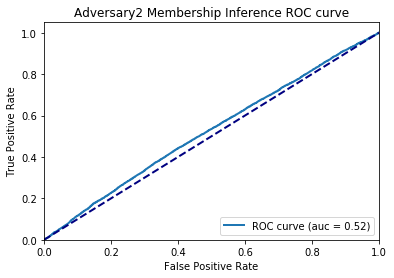

In [41]:
fpr, tpr, roc_auc = eval_attack_roc(attack_net, target_net, cifar100_trainloader, cifar100_testloader, k)
#eval_attack_net(attack_net, shadow_net, shadow_train_loader, shadow_out_loader, k)

lw = 2
plt.figure()
plt.plot(fpr, tpr, lw=lw, 
         label='ROC curve (auc = %.2f)' % (roc_auc))
plt.plot([0,1],[0,1], color='navy', lw=lw, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.xlim([0.0,1.0])
plt.ylim([0.0, 1.05])
plt.title('Adversary2 Membership Inference ROC curve')
plt.legend(loc="lower right")
plt.show()


results = (fpr, tpr, roc_auc)
pickle.dump(results, open("adv2_cifar100_lfw_results", "wb"))


# Part  - 2: Same dataset different models

In [0]:
# import necessary libraries 
import sys 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch
import torchvision 
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

# Hyperparameters

In [0]:
n_epochs = 7
batch_size = 128
lr = 0.01
k = 3



# Load data - CIFAR10

0it [00:00, ?it/s]

170500096it [00:02, 70009463.24it/s]                               


Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


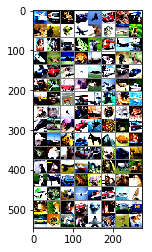

In [44]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
    

classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]


# load training set 
cifar10_trainset = torchvision.datasets.CIFAR10('../../../Datasets/', train=True, transform=train_transform, download=True)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# load test set 
cifar10_testset = torchvision.datasets.CIFAR10('../../../Datasets/', train=False, transform=test_transform, download=True)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=32, shuffle=False, num_workers=2)

# helper function to unnormalize and plot image 
def imshow(img):
    img = np.array(img)
    img = img / 2 + 0.5
    img = np.moveaxis(img, 0, -1)
    plt.imshow(img)
    
# display sample from dataset 
imgs,labels = iter(cifar10_trainloader).next()
imshow(torchvision.utils.make_grid(imgs))

# Membership Inference Attack

In [0]:
target_net_type = mlleaks_cnn
shadow_net_type = tiny_cnn

In [0]:
total_size = len(cifar10_trainset)
split1 = total_size // 4
split2 = split1*2
split3 = split1*3

indices = list(range(total_size))

shadow_train_idx = indices[:split1]
shadow_out_idx = indices[split1:split2]
target_train_idx = indices[split2:split3]
target_out_idx = indices[split3:]


shadow_train_sampler = SubsetRandomSampler(shadow_train_idx)
shadow_out_sampler = SubsetRandomSampler(shadow_out_idx)
target_train_sampler = SubsetRandomSampler(target_train_idx)
target_out_sampler = SubsetRandomSampler(target_out_idx)

shadow_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_train_sampler, num_workers=1)
shadow_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=shadow_out_sampler, num_workers=1)

target_train_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_train_sampler, num_workers=1)
target_out_loader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, sampler=target_out_sampler, num_workers=1)


# the model being attacked (architecture can be different than shadow)
target_net = target_net_type()
target_net.apply(weights_init)

target_loss = nn.CrossEntropyLoss()
target_optim = optim.Adam(target_net.parameters(), lr=lr)


# shadow net mimics the target network (architecture can be different than target)
shadow_net = shadow_net_type()
shadow_net.apply(weights_init)

shadow_loss = nn.CrossEntropyLoss()
shadow_optim = optim.Adam(shadow_net.parameters(), lr=lr)


# attack net is a binary classifier to determine membership 

attack_net = mlleaks_mlp(n_in=k)
attack_net.apply(weights_init)

attack_loss = nn.BCEWithLogitsLoss()
#attack_loss = nn.BCELoss()
attack_optim = optim.Adam(attack_net.parameters(), lr=lr)

# Train target model

In [47]:
train(target_net, target_train_loader, cifar10_testloader, target_optim, target_loss, n_epochs, classes=classes)

[0/7]
Training:
Accuracy of airplane : 0.00 %
Accuracy of automobile : 19.27 %
Accuracy of bird : 2.93 %
Accuracy of cat : 8.73 %
Accuracy of deer : 16.19 %
Accuracy of dog : 0.15 %
Accuracy of frog : 1.71 %
Accuracy of horse : 8.09 %
Accuracy of ship : 5.79 %
Accuracy of truck : 7.61 %

Accuracy = 29.54 %


Test:
Accuracy of airplane : 18.40 %
Accuracy of automobile : 15.20 %
Accuracy of bird : 21.70 %
Accuracy of cat : 24.70 %
Accuracy of deer : 6.20 %
Accuracy of dog : 21.00 %
Accuracy of frog : 1.90 %
Accuracy of horse : 3.90 %
Accuracy of ship : 5.00 %
Accuracy of truck : 23.20 %

Accuracy = 29.48 %


[1/7]
Training:
Accuracy of airplane : 3.34 %
Accuracy of automobile : 10.65 %
Accuracy of bird : 9.58 %
Accuracy of cat : 20.43 %
Accuracy of deer : 12.32 %
Accuracy of dog : 16.60 %
Accuracy of frog : 17.07 %
Accuracy of horse : 9.79 %
Accuracy of ship : 18.68 %
Accuracy of truck : 12.52 %

Accuracy = 41.76 %


Test:
Accuracy of airplane : 20.60 %
Accuracy of automobile : 0.10 %
Ac

(61.832, 53.47)

# Train shadow model

In [48]:
train(shadow_net, shadow_train_loader, cifar10_testloader, shadow_optim, shadow_loss, n_epochs, classes=classes)

[0/7]
Training:
Accuracy of airplane : 18.88 %
Accuracy of automobile : 11.06 %
Accuracy of bird : 11.36 %
Accuracy of cat : 7.93 %
Accuracy of deer : 11.44 %
Accuracy of dog : 14.41 %
Accuracy of frog : 7.89 %
Accuracy of horse : 5.61 %
Accuracy of ship : 0.16 %
Accuracy of truck : 0.66 %

Accuracy = 29.41 %


Test:
Accuracy of airplane : 15.90 %
Accuracy of automobile : 10.40 %
Accuracy of bird : 3.60 %
Accuracy of cat : 20.30 %
Accuracy of deer : 5.70 %
Accuracy of dog : 13.70 %
Accuracy of frog : 8.90 %
Accuracy of horse : 6.20 %
Accuracy of ship : 17.40 %
Accuracy of truck : 12.80 %

Accuracy = 29.41 %


[1/7]
Training:
Accuracy of airplane : 1.26 %
Accuracy of automobile : 5.16 %
Accuracy of bird : 6.39 %
Accuracy of cat : 4.95 %
Accuracy of deer : 3.06 %
Accuracy of dog : 8.63 %
Accuracy of frog : 12.46 %
Accuracy of horse : 8.42 %
Accuracy of ship : 16.47 %
Accuracy of truck : 9.00 %

Accuracy = 34.22 %


Test:
Accuracy of airplane : 18.70 %
Accuracy of automobile : 21.00 %
Acc

(61.944, 54.08)

# Train attack model

In [49]:
train_attacker(attack_net, shadow_net, shadow_train_loader, shadow_out_loader, attack_optim, attack_loss, n_epochs=7, k=k)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


[0/7][0/98] loss = 0.71, accuracy = 50.00
[0/7][1/98] loss = 0.69, accuracy = 50.00
[0/7][2/98] loss = 0.70, accuracy = 50.00
[0/7][3/98] loss = 0.70, accuracy = 50.00
[0/7][4/98] loss = 0.69, accuracy = 50.00
[0/7][5/98] loss = 0.69, accuracy = 50.00
[0/7][6/98] loss = 0.70, accuracy = 50.00
[0/7][7/98] loss = 0.70, accuracy = 50.00
[0/7][8/98] loss = 0.70, accuracy = 50.00
[0/7][9/98] loss = 0.69, accuracy = 50.00
[0/7][10/98] loss = 0.69, accuracy = 50.00
[0/7][11/98] loss = 0.69, accuracy = 50.00
[0/7][12/98] loss = 0.70, accuracy = 50.00
[0/7][13/98] loss = 0.70, accuracy = 50.00
[0/7][14/98] loss = 0.69, accuracy = 50.00
[0/7][15/98] loss = 0.69, accuracy = 49.98
[0/7][16/98] loss = 0.69, accuracy = 49.98
[0/7][17/98] loss = 0.69, accuracy = 49.98
[0/7][18/98] loss = 0.69, accuracy = 49.98
[0/7][19/98] loss = 0.69, accuracy = 49.98
[0/7][20/98] loss = 0.69, accuracy = 49.98
[0/7][21/98] loss = 0.69, accuracy = 49.98
[0/7][22/98] loss = 0.69, accuracy = 49.98
[0/7][23/98] loss = 0

# Evaluate attack

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


threshold = 0.5000, accuracy = 50.55, precision = 0.51, recall = 0.53
threshold = 0.5050, accuracy = 50.56, precision = 0.51, recall = 0.26
threshold = 0.5100, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5150, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5200, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5250, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5300, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5350, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5400, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5450, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5500, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5550, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5600, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5650, accuracy = 50.00, precision = 0.00, recall = 0.00
threshold = 0.5700, 

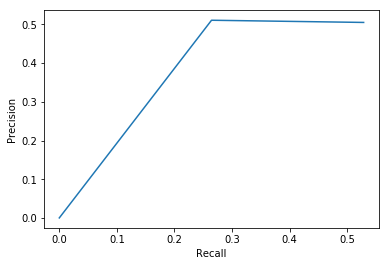


Performance on training set: 

Accuracy = 61.83 %



Performance on test set: 

Accuracy = 53.47 %




In [50]:
eval_attack_net(attack_net, target_net, target_train_loader, target_out_loader, k)

print("\nPerformance on training set: ")
train_accuracy = eval_target_net(target_net, target_train_loader, classes=None)

print("\nPerformance on test set: ")
test_accuracy = eval_target_net(target_net, cifar10_testloader, classes=None)